In [2]:
!pip install mftool pandas numpy openpyxl tqdm

In [3]:
from mftool import Mftool
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import time

pd.set_option("display.max_columns", 50)

# ---- Config ----
NUM_FUNDS = 500          # how many schemes to process (you can raise it)
REQUEST_DELAY = 0.15     # polite delay between API calls (seconds)
RISK_FREE_RATE = 0.06    # 6% assumed risk-free rate for Sharpe (adjust if you like)
OUTPUT_FILE = f"mf_analysis_{datetime.today():%Y%m%d}.xlsx"

mf = Mftool()
all_schemes = mf.get_scheme_codes()       # dict: {scheme_code: scheme_name}
scheme_subset = dict(list(all_schemes.items())[:NUM_FUNDS])  # first N schemes
len(scheme_subset), list(scheme_subset.items())[:3]


(500,
 [('Scheme Code', 'Scheme Name'),
  ('119551', 'Aditya Birla Sun Life Banking & PSU Debt Fund  - DIRECT - IDCW'),
  ('119552',
   'Aditya Birla Sun Life Banking & PSU Debt Fund  - DIRECT - MONTHLY IDCW')])

In [4]:
def _parse_date_any(s):
    """Robust date parser for mfapi strings."""
    for fmt in ("%d-%m-%Y", "%d-%b-%Y", "%Y-%m-%d"):
        try:
            return datetime.strptime(s, fmt)
        except Exception:
            pass
    # last resort
    return pd.to_datetime(s, errors="coerce")

def history_to_df(history_dict):
    """Convert mftool history dict to a clean DataFrame with datetime + float NAV."""
    if not history_dict or "data" not in history_dict:
        return None
    df = pd.DataFrame(history_dict["data"])
    if df.empty or "date" not in df or "nav" not in df:
        return None
    df["date"] = df["date"].apply(_parse_date_any)
    df = df.dropna(subset=["date"]).copy()
    df["nav"] = pd.to_numeric(df["nav"], errors="coerce")
    df = df.dropna(subset=["nav"]).sort_values("date").reset_index(drop=True)
    return df

def nav_closest(df, target_dt):
    """Return (nav, actual_date) closest to target_dt."""
    idx = (df["date"] - target_dt).abs().idxmin()
    row = df.loc[idx]
    return float(row["nav"]), pd.to_datetime(row["date"])

def cagr_between(df, start_dt, end_dt):
    """CAGR using NAV closest to start_dt and end_dt."""
    df = df[(df["date"] <= end_dt)].copy()
    if df.empty: 
        return np.nan
    end_nav, end_used = nav_closest(df, end_dt)
    start_nav, start_used = nav_closest(df, start_dt)
    if start_nav <= 0 or end_nav <= 0:
        return np.nan
    years = (end_used - start_used).days / 365.25
    if years <= 0:
        return np.nan
    return (end_nav / start_nav) ** (1 / years) - 1

def annualized_volatility(df):
    """Std dev of daily returns, annualized (≈252 trading days)."""
    r = df["nav"].pct_change().dropna()
    if r.empty:
        return np.nan
    return r.std() * np.sqrt(252)

def max_drawdown(df):
    """Maximum drawdown from NAV series."""
    nav = df["nav"].values
    if len(nav) < 2:
        return np.nan
    cum_max = np.maximum.accumulate(nav)
    dd = nav / cum_max - 1.0
    return float(dd.min())

def sharpe_ratio(cagr, vol, rf=RISK_FREE_RATE):
    """Sharpe using CAGR as annual return and annualized vol."""
    if pd.isna(cagr) or pd.isna(vol) or vol == 0:
        return np.nan
    return (cagr - rf) / vol


In [5]:
records = []
errors = []

today = datetime.today()
dt_1y = today - timedelta(days=365)
dt_3y = today - timedelta(days=3*365)
dt_5y = today - timedelta(days=5*365)

for code, name in tqdm(scheme_subset.items(), total=len(scheme_subset)):
    try:
        raw = mf.get_scheme_historical_nav(code)
        df = history_to_df(raw)
        if df is None or df.empty:
            errors.append((code, name, "empty history"))
            time.sleep(REQUEST_DELAY); 
            continue

        latest_nav = float(df["nav"].iloc[-1])

        # Returns
        r_1y = cagr_between(df, dt_1y, today)
        r_3y = cagr_between(df, dt_3y, today)
        r_5y = cagr_between(df, dt_5y, today)

        # Risk
        vol = annualized_volatility(df)
        mdd = max_drawdown(df)

        # Sharpe (prefer 3Y, else 1Y)
        base_return = r_3y if not pd.isna(r_3y) else r_1y
        sr = sharpe_ratio(base_return, vol, rf=RISK_FREE_RATE)

        records.append({
            "Scheme Code": code,
            "Scheme Name": name,
            "Latest NAV": latest_nav,
            "1Y Return (CAGR)": r_1y,
            "3Y Return (CAGR)": r_3y,
            "5Y Return (CAGR)": r_5y,
            "Volatility (Annualized)": vol,
            "Sharpe Ratio": sr,
            "Max Drawdown": mdd,
            "Last Date": df["date"].iloc[-1].date()
        })
    except Exception as e:
        errors.append((code, name, str(e)))
    finally:
        time.sleep(REQUEST_DELAY)

len(records), len(errors)


  3%|▎         | 13/500 [00:17<10:43,  1.32s/it]c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
  3%|▎         | 14/500 [00:20<15:50,  1.96s/it]c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
  3%|▎         | 15/500 [00:21<12:40,  1.57s/it]c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
  3%|▎         | 16/500 [00:22<11:04,  1.37s/it]c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
  4%|▎         | 18/500 [00:24<09:30,  1.18s/it]c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure

(499, 1)

In [6]:
summary = pd.DataFrame(records)

# percentage columns for display (keep raw values for Excel saving next)
display_cols = [
    "Scheme Code", "Scheme Name", "Latest NAV",
    "1Y Return (CAGR)", "3Y Return (CAGR)", "5Y Return (CAGR)",
    "Volatility (Annualized)", "Sharpe Ratio", "Max Drawdown", "Last Date"
]
summary_display = summary[display_cols].copy()

pct_cols = ["1Y Return (CAGR)", "3Y Return (CAGR)", "5Y Return (CAGR)", "Volatility (Annualized)", "Max Drawdown"]
summary_display_style = summary_display.style.format({
    "Latest NAV": "{:,.2f}",
    "1Y Return (CAGR)": "{:.2%}",
    "3Y Return (CAGR)": "{:.2%}",
    "5Y Return (CAGR)": "{:.2%}",
    "Volatility (Annualized)": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}",
})

summary_display.head(15), summary_display_style


(   Scheme Code                                        Scheme Name  Latest NAV  \
 0       119551  Aditya Birla Sun Life Banking & PSU Debt Fund ...    107.9266   
 1       119552  Aditya Birla Sun Life Banking & PSU Debt Fund ...    117.3946   
 2       119553  Aditya Birla Sun Life Banking & PSU Debt Fund ...    105.0878   
 3       108272  Aditya Birla Sun Life Banking & PSU Debt Fund ...    151.5261   
 4       110282  Aditya Birla Sun Life Banking & PSU Debt Fund ...    113.1383   
 5       108274  Aditya Birla Sun Life Banking & PSU Debt Fund ...    102.9831   
 6       110490  Aditya Birla Sun Life Banking & PSU Debt Fund ...    113.0993   
 7       106157  Aditya Birla Sun Life Banking & PSU Debt Fund ...    104.1092   
 8       108273  Aditya Birla Sun Life Banking & PSU Debt Fund ...    368.9044   
 9       103176  Aditya Birla Sun Life Banking & PSU Debt Fund ...    553.7758   
 10      119550  Aditya Birla Sun Life Banking & PSU Debt Fund-...    383.0766   
 11      128952 

In [7]:
# Prepare raw long-form NAV table too (optional but handy)
# This re-fetches minimally to avoid large memory; skip if not needed.
raw_rows = []
for code, name in tqdm(scheme_subset.items(), total=len(scheme_subset)):
    try:
        raw = mf.get_scheme_historical_nav(code)
        df = history_to_df(raw)
        if df is None or df.empty: 
            continue
        tmp = df.copy()
        tmp["scheme_code"] = code
        tmp["scheme_name"] = name
        raw_rows.append(tmp[["scheme_code", "scheme_name", "date", "nav"]])
        time.sleep(REQUEST_DELAY)
    except Exception:
        pass

raw_nav = pd.concat(raw_rows, ignore_index=True) if raw_rows else pd.DataFrame(columns=["scheme_code","scheme_name","date","nav"])

# Write Excel
with pd.ExcelWriter(OUTPUT_FILE, engine="openpyxl") as writer:
    summary.to_excel(writer, sheet_name="Summary", index=False)
    raw_nav.to_excel(writer, sheet_name="Raw_NAV", index=False)
    if errors:
        pd.DataFrame(errors, columns=["scheme_code", "scheme_name", "error"]).to_excel(writer, sheet_name="Errors", index=False)

OUTPUT_FILE

100%|██████████| 500/500 [03:21<00:00,  2.48it/s]


'mf_analysis_20250829.xlsx'

In [8]:
top_sharpe = summary.sort_values("Sharpe Ratio", ascending=False).head(25)
top_sharpe[["Scheme Code","Scheme Name","Sharpe Ratio","3Y Return (CAGR)","Volatility (Annualized)"]].head(10)

,Scheme Code,Scheme Name,Sharpe Ratio,3Y Return (CAGR),Volatility (Annualized)
473,101837,DSP Credit Risk Fund - Regular Plan -Growth,2.496076,0.145597,0.034293
463,119082,DSP Credit Risk Fund - Direct Plan - Growth,2.198709,0.154669,0.043057
25,152162,Bajaj Finserv Banking and PSU Fund-Direct Plan...,2.180794,0.085223,0.011566
22,152163,Bajaj Finserv Banking and PSU Fund- Direct Pla...,2.180794,0.085223,0.011566
412,134387,Aditya Birla Sun Life Credit Risk Fund - Direc...,2.089587,0.112879,0.025306
411,134388,Aditya Birla Sun Life Credit Risk Fund - Direc...,2.089290,0.112875,0.025307
111,148536,ITI Banking & PSU Debt Fund - Direct Plan - ID...,2.077777,0.075217,0.007324
110,148534,ITI Banking & PSU Debt Fund - Direct Plan - Gr...,2.073449,0.075183,0.007322
331,118814,Nippon India Corporate Bond Fund - Direct Plan...,1.962549,0.081336,0.010872
330,118807,Nippon India Corporate Bond Fund - Direct Plan...,1.960209,0.081335,0.010884


In [12]:


# Load results from your Excel file
df = pd.read_excel("mf_analysis_20250829.xlsx")

# Step 1: Clean NaNs (some funds don’t have full 5Y history)
df = df.dropna(subset=["3Y Return (CAGR)", "5Y Return (CAGR)", "Sharpe Ratio"])

# Step 2: Normalization (scale metrics between 0 and 1 for fair comparison)
for col in ["1Y Return (CAGR)", "3Y Return (CAGR)", "5Y Return (CAGR)", 
            "Sharpe Ratio"]:
    df[col+"_norm"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# For Volatility & Drawdown → lower is better, so reverse scale
for col in ["Volatility (Annualized)", "Max Drawdown"]:
    df[col+"_norm"] = 1 - (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Step 3: Weighted Score
df["Score"] = (
    0.2 * df["1Y Return (CAGR)_norm"] +
    0.2 * df["3Y Return (CAGR)_norm"] +
    0.3 * df["5Y Return (CAGR)_norm"] +
    0.2 * df["Sharpe Ratio"] +
    0.05 * df["Volatility (Annualized)_norm"] +
    0.05 * df["Max Drawdown_norm"]
)

# Step 4: Sort funds by score
top_funds = df.sort_values("Score", ascending=False).head(20)

top_funds[["Scheme Name", "Latest NAV", "1Y Return (CAGR)", 
           "3Y Return (CAGR)", "5Y Return (CAGR)", 
           "Sharpe Ratio", "Volatility (Annualized)", 
           "Max Drawdown", "Score"]]


,Scheme Name,Latest NAV,1Y Return (CAGR),3Y Return (CAGR),5Y Return (CAGR),Sharpe Ratio,Volatility (Annualized),Max Drawdown,Score
473,DSP Credit Risk Fund - Regular Plan -Growth,49.8591,0.219504,0.145597,0.113775,2.496076,0.034293,-0.061788,1.106587
463,DSP Credit Risk Fund - Direct Plan - Growth,54.4837,0.228848,0.154669,0.122730,2.198709,0.043057,-0.059793,1.067347
412,Aditya Birla Sun Life Credit Risk Fund - Direc...,24.7995,0.171854,0.112879,0.102943,2.089587,0.025306,-0.038708,0.960542
411,Aditya Birla Sun Life Credit Risk Fund - Direc...,24.7984,0.171858,0.112875,0.102945,2.089290,0.025307,-0.038715,0.960484
25,Bajaj Finserv Banking and PSU Fund-Direct Plan...,11.5873,0.083782,0.085223,0.085223,2.180794,0.011566,-0.007604,0.885031
22,Bajaj Finserv Banking and PSU Fund- Direct Pla...,11.5873,0.083782,0.085223,0.085223,2.180794,0.011566,-0.007604,0.885031
415,Aditya Birla Sun Life Credit Risk Fund - Regul...,22.6015,0.161760,0.103204,0.093472,1.709172,0.025278,-0.040011,0.862798
111,ITI Banking & PSU Debt Fund - Direct Plan - ID...,13.4855,0.081286,0.075217,0.063650,2.077777,0.007324,-0.010584,0.836658
110,ITI Banking & PSU Debt Fund - Direct Plan - Gr...,13.4842,0.081181,0.075183,0.063629,2.073449,0.007322,-0.010584,0.835682
331,Nippon India Corporate Bond Fund - Direct Plan...,63.4651,0.088005,0.081336,0.070763,1.962549,0.010872,-0.016976,0.829022


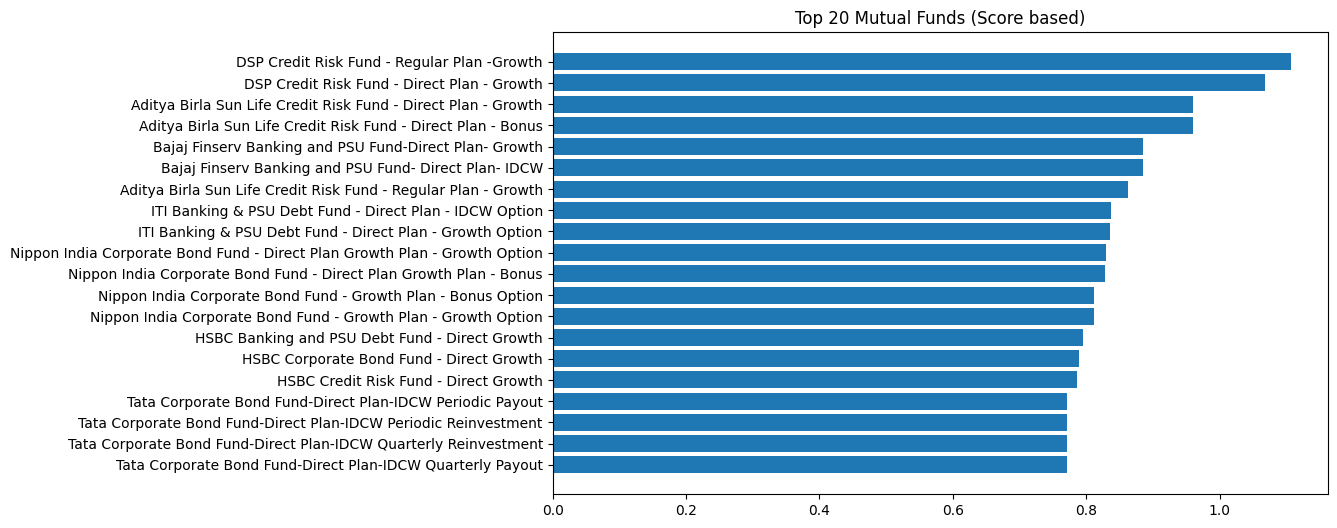

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top_funds["Scheme Name"], top_funds["Score"])
plt.gca().invert_yaxis()
plt.title("Top 20 Mutual Funds (Score based)")
plt.show()
